In [1]:
import torch
from tqdm import tqdm
import deepinv as dinv

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

torch.manual_seed(42)
torch.cuda.manual_seed(42)

torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = False

## Diffraction blurs

In [3]:
from deepinv.physics.generator import DiffractionBlurGenerator
from deepinv.physics import BlurFFT, GaussianNoise

# Define the generator for diffraction blurs
generator = DiffractionBlurGenerator(psf_size=(31, 31),
                                    list_param=["Z4", "Z5", "Z6", "Z7"],
                                    device=device,
                                    dtype=dtype)

# Define the physics model -- the Convolution with FFT
SIGMA = 0.01 
physics = BlurFFT(img_size=(3, 256, 256), noise_model = GaussianNoise(sigma=SIGMA), device=device, dtype=dtype)
x = torch.load('./save/six_random_image.pt', map_location=device)[0:1]
x = x.to(device=device, dtype=dtype)

# Generate a random diffraction kernel 
zernike_coef = torch.tensor([[0.15, 0.1, 0.15, -0.1]], device=device, dtype=dtype)
kernel = generator.step(1, coeff=zernike_coef)['filter']

# Apply the physics model to generate the blurred image
y = physics(x, filter=kernel)

dinv.utils.plot([x, kernel, y], titles=["Original image", "Diffraction kernel", "Blurred image"])


### Optimization

Load a pretrained Score model

In [4]:
from songdiff import get_gradient_fn
from functools import partial

score_fn = get_gradient_fn(name = 'ncsnpp_ffhq256', device=device, dtype=dtype)
grad_prior_fn = partial(score_fn, t=0.3)
# Test denoising 
with torch.no_grad():
    score = score_fn(y, SIGMA)
    y_denoised = y + SIGMA ** 2 * score
dinv.utils.plot([y, y_denoised], titles=["Blurred image", "Denoised image"])

/home/minhhai/miniforge3/envs/dev/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/minhhai/miniforge3/envs/dev/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


For this parameterized blur kernel with Zernike coefficients, the following helper functions can be used to compute the gradient of the posterior w.r.t the coefficient, by leveraging automatic differentiation

In [5]:
def grad_zernike_coeff(zernike_coef, y, x, physics, generator, data_fid):
    zernike_coef = zernike_coef.clone().detach()
    with torch.enable_grad():
        zernike_coef.requires_grad_(True)
        kernel = generator.step(1, coeff=zernike_coef)['filter']
        physics.update_parameters(filter=kernel)
        data_fid_loss = data_fid(x = x, y = y, physics = physics) / y.numel()
        data_fid_loss.backward()
    return zernike_coef.grad.detach()

With this parametrized PSF family, we will optimize the Zernike coefficients

Blind deblurring with Diffraction blur:   7%|▋         | 49/700 [00:12<01:22,  7.88it/s]

Blind deblurring with Diffraction blur:  14%|█▍        | 99/700 [00:19<01:19,  7.54it/s]

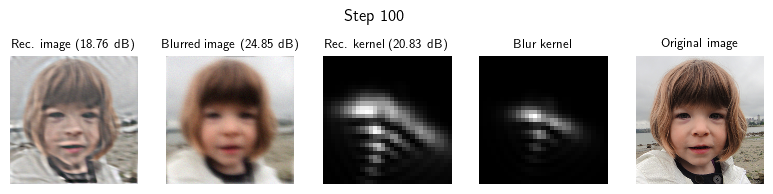

Blind deblurring with Diffraction blur:  21%|██▏       | 149/700 [00:26<01:08,  7.99it/s]

Blind deblurring with Diffraction blur:  28%|██▊       | 199/700 [00:32<01:00,  8.23it/s]

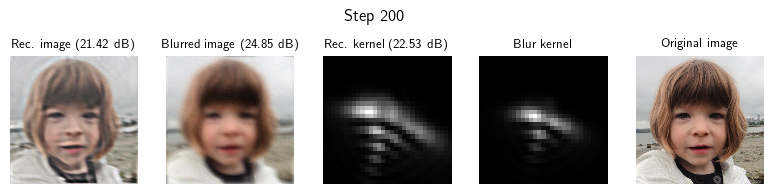

Blind deblurring with Diffraction blur:  36%|███▌      | 249/700 [00:39<00:58,  7.72it/s]

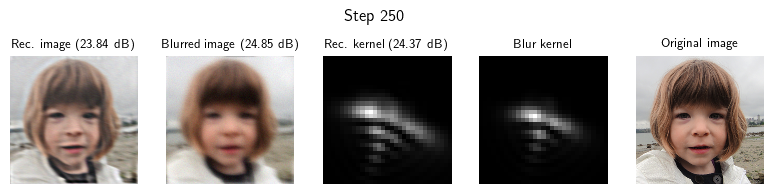

Blind deblurring with Diffraction blur:  43%|████▎     | 299/700 [00:46<00:53,  7.56it/s]

Blind deblurring with Diffraction blur:  50%|████▉     | 349/700 [00:52<00:43,  8.14it/s]

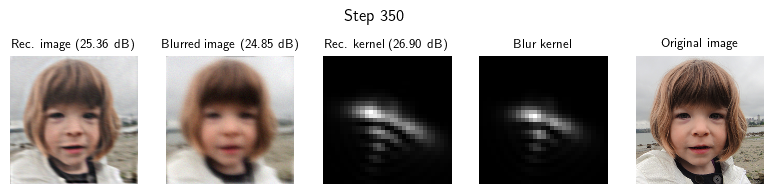

Blind deblurring with Diffraction blur:  57%|█████▋    | 399/700 [00:59<00:40,  7.51it/s]

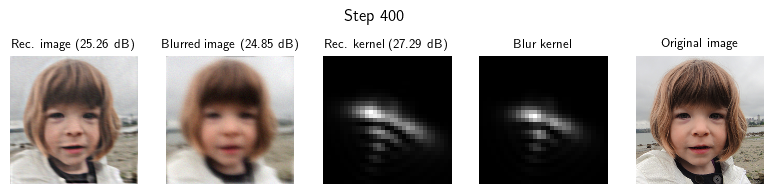

Blind deblurring with Diffraction blur:  64%|██████▍   | 449/700 [01:06<00:31,  7.92it/s]

Blind deblurring with Diffraction blur:  71%|███████▏  | 499/700 [01:13<00:29,  6.92it/s]

Blind deblurring with Diffraction blur:  78%|███████▊  | 549/700 [01:20<00:18,  8.12it/s]

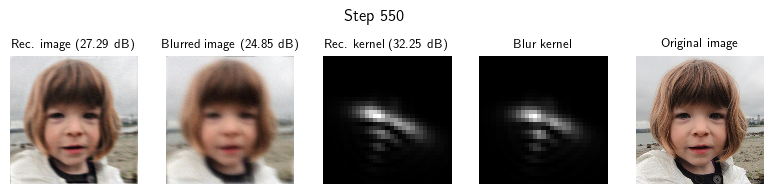

Blind deblurring with Diffraction blur:  86%|████████▌ | 599/700 [01:27<00:13,  7.62it/s]

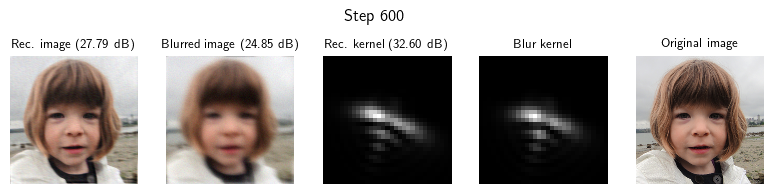

Blind deblurring with Diffraction blur:  93%|█████████▎| 649/700 [01:34<00:06,  7.71it/s]

Blind deblurring with Diffraction blur: 100%|█████████▉| 699/700 [01:41<00:00,  8.13it/s]

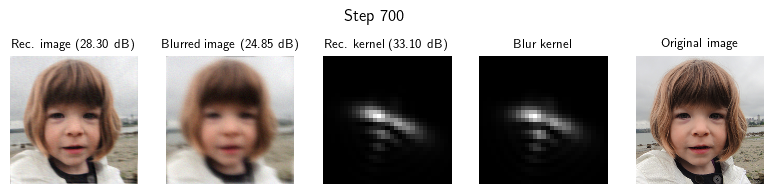

Blind deblurring with Diffraction blur: 100%|██████████| 700/700 [01:41<00:00,  6.88it/s]


In [6]:
y_psnr = dinv.metric.cal_psnr(y, x).item()

# Initialize with a larger kernel
coef_hat = zernike_coef + 0.075 * torch.sign(zernike_coef)

kernel_hat = generator.step(1, coeff=coef_hat)['filter']
physics.update_parameters(filter=kernel_hat)


x_hat = y.clone()
step_size_image = 1.
step_size_coef = 1.

data_fid = dinv.optim.L2()
psnr = dinv.metric.PSNR(max_pixel=None)

x_hat_psnr = psnr(x_hat, x).item()
kernel_hat_psnr = psnr(kernel_hat, kernel).item()
dinv.utils.plot([x_hat, y, kernel_hat, kernel, x], suptitle="Initial state", 
                titles=[f"Rec. image ({x_hat_psnr:.2f} dB)", 
                        f"Blurred image ({y_psnr:.2f} dB)", 
                        f"Rec. kernel ({kernel_hat_psnr:.2f} dB)", 
                        "Blur kernel",
                        "Original image"])

n_iter = 700
reset_iter = 100
for i in tqdm(range(n_iter), desc="Blind deblurring with Diffraction blur"):
    if i % reset_iter == 0:
        x_hat = y.clone()
    with torch.no_grad():
        # Minimize over the image by proximal gradient descent
        n_iter_x = 5 if i < int(0.25 * reset_iter) else 1 
        for j in range(n_iter_x):
            x_hat = x_hat + step_size_image * SIGMA ** 2 * grad_prior_fn(x_hat)
            x_hat = data_fid.prox(x_hat, y, physics, gamma=step_size_image)
            
        # A gradient descent step to denoise 
        x_hat = x_hat + step_size_image * SIGMA ** 2 * grad_prior_fn(x_hat)
                
        # A single gradient step for the Zernike coefficients of the blur kernel
        coef_grad = grad_zernike_coeff(coef_hat, y, x_hat, physics, generator, data_fid)
        coef_hat = coef_hat - step_size_coef * coef_grad 
            
        # Update the generator with the new coefficients
        kernel_hat = generator.step(1, coeff=coef_hat)['filter']
        physics.update_parameters(filter=kernel_hat)
        
        if (i + 1) % 50 == 0:
            x_hat_psnr = psnr(x_hat, x).item()
            kernel_hat_psnr = psnr(kernel_hat, kernel).item()
            
            dinv.utils.plot([x_hat, y, kernel_hat, kernel, x], suptitle=f"Step {i + 1}", 
                            titles=[f"Rec. image ({x_hat_psnr:.2f} dB)", 
                                    f"Blurred image ({y_psnr:.2f} dB)", 
                                    f"Rec. kernel ({kernel_hat_psnr:.2f} dB)", 
                                    "Blur kernel",
                                    "Original image"])


## Blind deblurring with real world dataset 

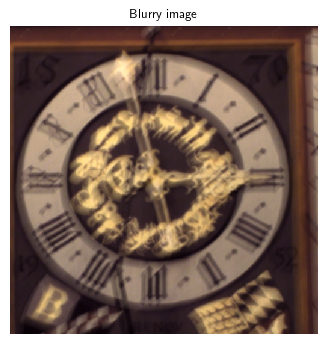

In [7]:
# Load image 
kernel_size = 31 
y = dinv.utils.load_image('./save/kohler_blurry_2_1.png', 
                          img_size=None,
                          device=device, dtype=dtype)

y = y[...,300-256:300+256, 400-256:400+256]

drunet = dinv.models.DRUNet(pretrained="download", device=device)
grad_prior_fn = lambda x: drunet(x, 0.4) - x

dinv.utils.plot([y], titles=["Blurry image"], figsize=(4, 4))

Starting optimization loop...
----------------------------------------------------------------------------------------------------
	 Outer iteration: 1 / 20


grad: 27361.172, 1.000e-07, l2 = 1197.39:   0%|          | 0/100 [00:08<?, ?it/s]

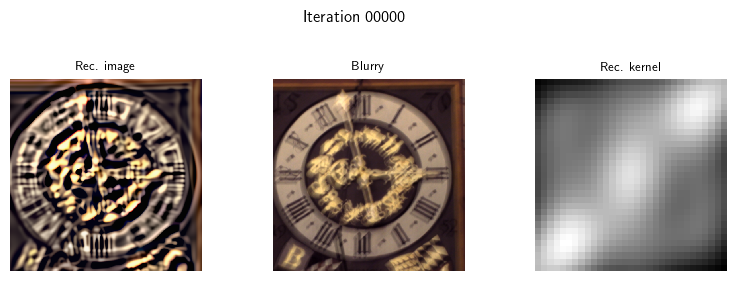

grad: 9672.649, 1.000e-07, l2 = 363.69: 100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 2 / 20


grad: 14284.797, 1.000e-07, l2 = 323.76:   0%|          | 0/100 [00:08<?, ?it/s]

grad: 6890.687, 1.000e-07, l2 = 239.20: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 3 / 20


grad: 10010.465, 1.000e-07, l2 = 226.05:   0%|          | 0/100 [00:08<?, ?it/s]

grad: 4845.672, 1.000e-07, l2 = 157.48: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 4 / 20


grad: 6297.035, 1.000e-07, l2 = 150.12:   0%|          | 0/100 [00:08<?, ?it/s]

grad: 3819.523, 1.000e-07, l2 = 115.35: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 5 / 20


grad: 4922.975, 1.000e-07, l2 = 109.18:   0%|          | 0/100 [00:08<?, ?it/s]

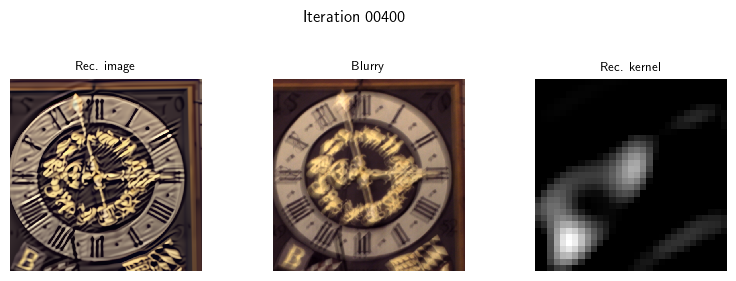

grad: 2871.684, 1.000e-07, l2 = 94.77: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 6 / 20


grad: 3706.325, 1.000e-07, l2 = 85.88:   0%|          | 0/100 [00:08<?, ?it/s]

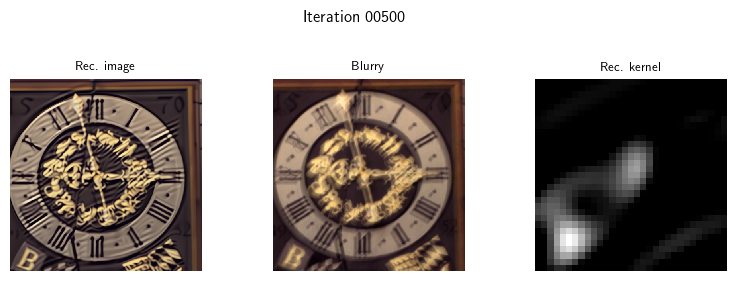

grad: 2406.510, 1.000e-07, l2 = 73.26: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 7 / 20


grad: 2748.509, 1.000e-07, l2 = 63.00:   0%|          | 0/100 [00:08<?, ?it/s]

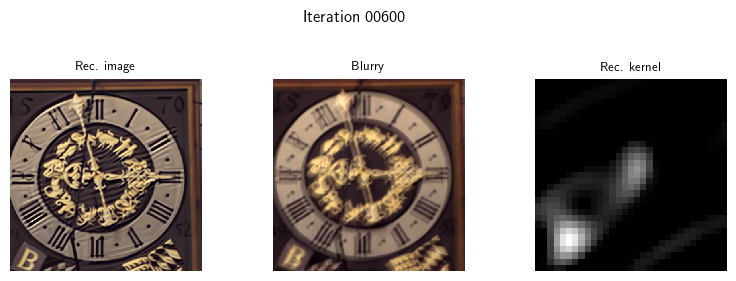

grad: 1357.005, 1.000e-07, l2 = 48.42: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 8 / 20


grad: 1460.679, 1.000e-07, l2 = 44.45:   0%|          | 0/100 [00:08<?, ?it/s]

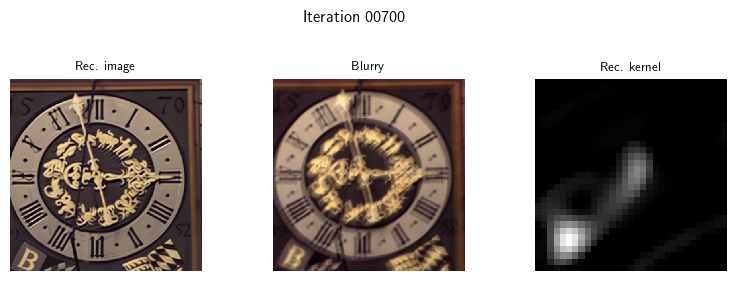

grad: 932.440, 1.000e-07, l2 = 43.74: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 9 / 20


grad: 891.313, 1.000e-07, l2 = 39.74:   0%|          | 0/100 [00:08<?, ?it/s]

grad: 742.750, 1.000e-07, l2 = 41.01: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 10 / 20


grad: 737.571, 1.000e-07, l2 = 37.25:   0%|          | 0/100 [00:08<?, ?it/s]

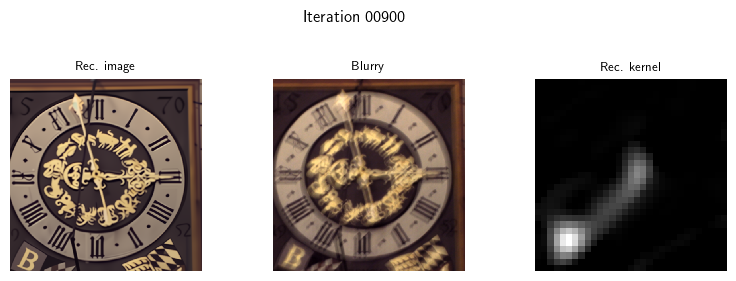

grad: 741.816, 1.000e-07, l2 = 38.93: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 11 / 20


grad: 652.161, 1.000e-07, l2 = 35.56:   0%|          | 0/100 [00:08<?, ?it/s]

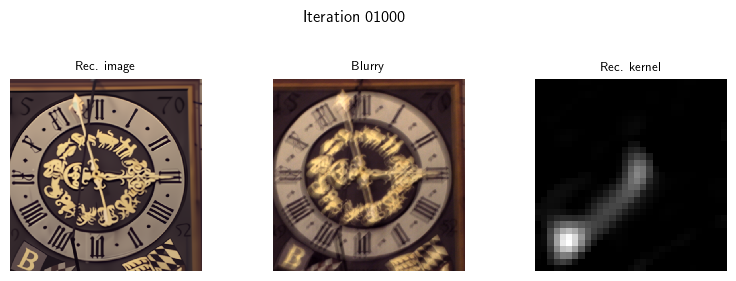

grad: 711.780, 1.000e-07, l2 = 37.52: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 12 / 20


grad: 602.382, 1.000e-07, l2 = 34.30:   0%|          | 0/100 [00:08<?, ?it/s]

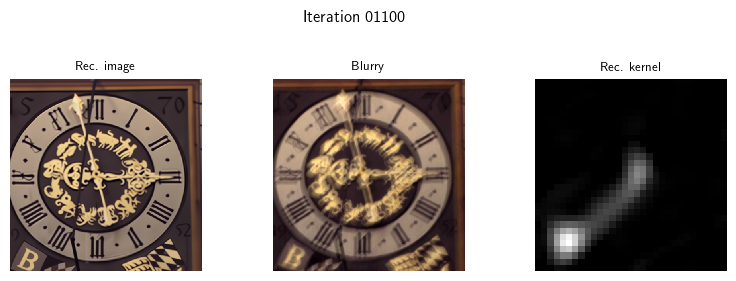

grad: 651.724, 1.000e-07, l2 = 36.06: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 13 / 20


grad: 560.358, 1.000e-07, l2 = 33.25:   0%|          | 0/100 [00:08<?, ?it/s]

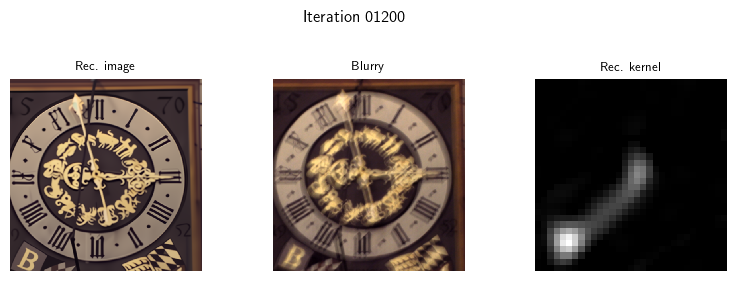

grad: 632.159, 1.000e-07, l2 = 35.22: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 14 / 20


grad: 522.240, 1.000e-07, l2 = 32.41:   0%|          | 0/100 [00:08<?, ?it/s]

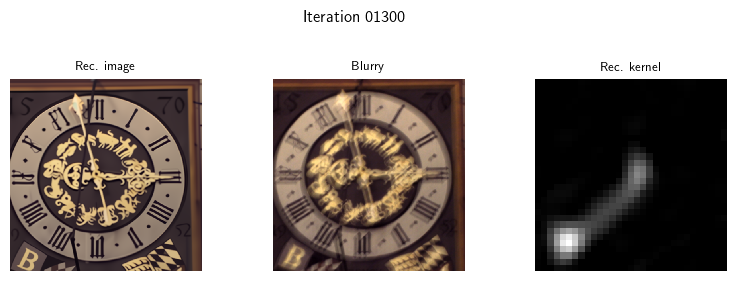

grad: 590.337, 1.000e-07, l2 = 34.25: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 15 / 20


grad: 496.302, 1.000e-07, l2 = 31.68:   0%|          | 0/100 [00:08<?, ?it/s]

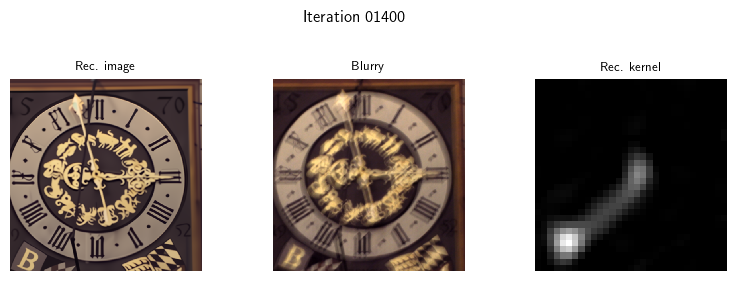

grad: 546.199, 1.000e-07, l2 = 33.78: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 16 / 20


grad: 478.320, 1.000e-07, l2 = 31.04:   0%|          | 0/100 [00:08<?, ?it/s]

grad: 540.846, 1.000e-07, l2 = 33.31: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 17 / 20


grad: 460.809, 1.000e-07, l2 = 30.48:   0%|          | 0/100 [00:08<?, ?it/s]

grad: 538.262, 1.000e-07, l2 = 32.70: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 18 / 20


grad: 448.661, 1.000e-07, l2 = 29.96:   0%|          | 0/100 [00:08<?, ?it/s]

grad: 519.308, 1.000e-07, l2 = 32.24: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 19 / 20


grad: 439.658, 1.000e-07, l2 = 29.48:   0%|          | 0/100 [00:08<?, ?it/s]

grad: 499.175, 1.000e-07, l2 = 31.92: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


----------------------------------------------------------------------------------------------------
	 Outer iteration: 20 / 20


grad: 435.851, 1.000e-07, l2 = 29.07:   0%|          | 0/100 [00:08<?, ?it/s]

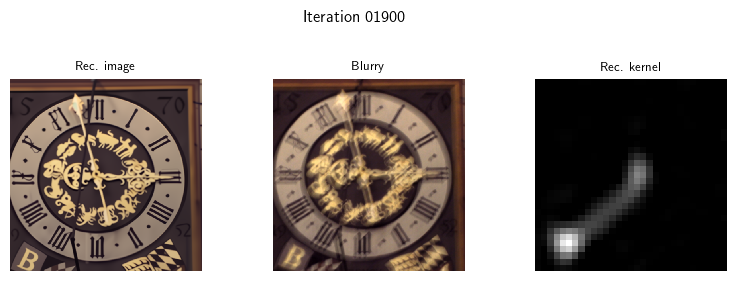

grad: 494.488, 1.000e-07, l2 = 31.58: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


In [10]:
import os
# For real blurry image, we use `valid` padding mode in convolution, which needs some careful border handling. We define such function and import it here
from putils.optimization import optimization_loop, projection_simplex_sort

kernel_init = torch.ones(1, 1, kernel_size, kernel_size, device=device, dtype=dtype)
kernel_init = projection_simplex_sort(kernel_init)

optimization_parameters = dict(
    outer_loop = 20, 
    max_num_steps = 100, 
    min_num_steps = 4,
    lr_x = 1,
    lr_kernel = 1e-2,
    n_iter = 100, 
    lamb = 2.,
    num_warmup_steps = 5,
    display_freq = 1000,
    lr_x_decay = 1.,
)
save_dir = "./kohler_blurry_2_1"  # Save directory for results
os.makedirs(save_dir, exist_ok=True)
x_evolution, kernel_evolution = optimization_loop(y, kernel_init, drunet, **optimization_parameters, save_dir=save_dir)

